# Iterative closest point
More details: https://en.wikipedia.org/wiki/Iterative_closest_point

In [22]:
# Import all the necessary toolbox for basic python development 
from simpleicp import PointCloud, SimpleICP
import numpy as np
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import spatialmath
import scipy
import sys 
from sklearn.neighbors import NearestNeighbors
from spatialmath import *
from spatialmath.base import *
from scipy.spatial.transform import Rotation as R
from scipy.linalg import eigh

%matplotlib widget  


In [23]:
# Read point clouds from xyz files into n-by-3 numpy arrays
X_fix = np.genfromtxt("bunny_part1.xyz")

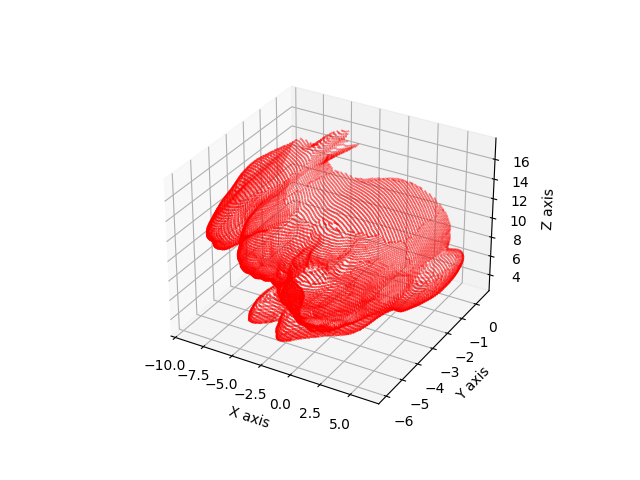

(20702, 3)


In [24]:
# Plot the cloud point X_fix
fig = plt.figure(1)      #create the figure
ax = fig.add_subplot(111, projection='3d')      #setup the 3D space

# Add the point to the figure
ax.scatter(X_fix[:, 0], X_fix[:, 1], X_fix[:, 2], c='r', marker='.', s=0.5)   
    

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the graph
plt.show(fig)

print(X_fix.shape)

In [25]:
# Build a transformation matrix with a translation of: 
# 2 along x, 
# 6 along y, 
# 0 along z
# and a rotation of:
# 15 degrees around z
# 20 degrees around x
 
translation = SE3(2,6,0)

rotation_x = SE3.Rx(20,unit='deg')
rotation_z = SE3.Rz(15,unit='deg')


T1 = translation * rotation_x * rotation_z
# Print the matrix T1
print(T1) #TODO

   0.9659   -0.2588    0         2         
   0.2432    0.9077   -0.342     6         
   0.08852   0.3304    0.9397    0         
   0         0         0         1         



In [26]:
# Create P_source which is equal to X_fix but transposed and with the homogenoues component 
P_source = np.zeros((4, 20702))
P_source[0,:] = X_fix[:, 0]
P_source[1,:] = X_fix[:, 1]
P_source[2,:] = X_fix[:, 2]
P_source[3,:] = 1

# Multiply T1 and P_source to obtain P_end (end point cloud) 
P_end = np.dot(T1, P_source)

# Exctract the array of points transposed back and without the homogenous component
PB = np.zeros((20702,3))
PB[:,0] = P_end[0,:]
PB[:,1] = P_end[1,:]
PB[:,2] = P_end[2,:]

print(P_end.shape)
print(PB.shape)

# Save PB into the variable X_mov
X_mov = PB

# Add some withe noise, impost the noise variable equal to 100 
mean_noise = 100

# In this way we add the random withe noise to our data
transf_points = PB + mean_noise * np.random.randn(*PB.shape)

# Traspose the array
transf_points_T = transf_points.T

# Sort the rows
transf_points_sorted = transf_points_T[np.argsort(transf_points_T[:, 0])]

# Transpose back
transf_points = transf_points_sorted.T


(4, 20702)
(20702, 3)


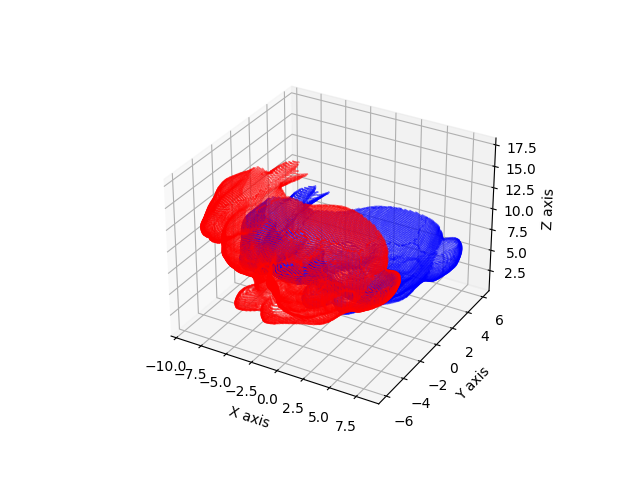

In [27]:
# Plot the two cloud points X_fix and X_mov
fig = plt.figure(2)      #create the figure
ax = fig.add_subplot(111, projection='3d')      #setup the 3D space

# Add the point to the figure
ax.scatter(X_fix[:, 0], X_fix[:, 1], X_fix[:, 2], c='r', marker='.', s=0.5)   
ax.scatter(X_mov[:, 0], X_mov[:, 1], X_mov[:, 2], c='b', marker='.', s=0.5) 

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the graph
plt.show(fig)

In [28]:
# Create point cloud objects
pc_fix = PointCloud(X_fix, columns=["x", "y", "z"])
pc_mov = PointCloud(X_mov, columns=["x", "y", "z"])

# Create simpleICP object, add point clouds, and run algorithm!
icp = SimpleICP()
icp.add_point_clouds(pc_fix, pc_mov)
H, X_mov_transformed, rigid_body_transformation_params, distance_residuals = icp.run(max_overlap_distance=50)

Consider partial overlap of point clouds ...
Select points for correspondences in fixed point cloud ...
Estimate normals of selected points ...
Start iterations ...
iteration | correspondences | mean(residuals) |  std(residuals)
   orig:0 |             974 |          0.0713 |          1.5009
        1 |             973 |          0.0860 |          1.1091
        2 |             857 |          0.0371 |          0.6019
        3 |             883 |          0.0354 |          0.5606
        4 |             883 |          0.0244 |          0.4928
        5 |             886 |          0.0078 |          0.4233
        6 |             884 |         -0.0021 |          0.3555
        7 |             888 |         -0.0039 |          0.3090
        8 |             903 |         -0.0084 |          0.2723
        9 |             888 |         -0.0080 |          0.2267
       10 |             862 |          0.0015 |          0.1861
       11 |             864 |         -0.0031 |          0.1479
   

In [29]:
# Print the two matrices and compare the estimated one with the original one
print('Matrix estimatied with ICP: \n', H) #estimated ICP
print('\nMatrix original:\n', T1) #original

Matrix estimatied with ICP: 
 [[ 9.65925826e-01  2.43210347e-01  8.85213269e-02 -3.39111373e+00]
 [-2.58819045e-01  9.07673371e-01  3.30366090e-01 -4.92840214e+00]
 [ 5.55111512e-17 -3.42020143e-01  9.39692621e-01  2.05212086e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Matrix original:
    0.9659   -0.2588    0         2         
   0.2432    0.9077   -0.342     6         
   0.08852   0.3304    0.9397    0         
   0         0         0         1         



Dimensions:
H: (4, 4) 
X_fix: (20702, 3)
Mean Squared Error: [4.00000000e+00 3.60000000e+01 6.35543262e-31]


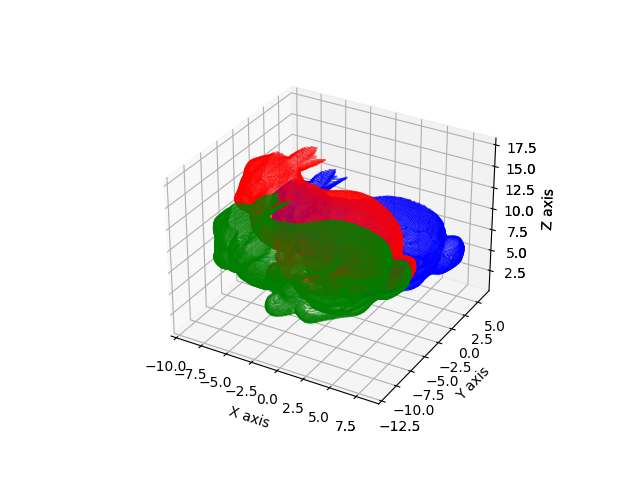

In [ ]:
# Homework: #TODO
# Compute X_estimated multiplying the estimated transformation matrix H with the original cloud point X_fix
# Plot the three cloud points (X_fix, X_mov, X_estimated) and check if the transformation was successfully estimated 

'''
X_fix = np.array(...)  # Fixed point cloud, shape (20702, 3)
X_mov = np.array(...)  # Moving point cloud, shape (20702, 3)
H = np.array(...)      # Transformation matrix, shape (4, 4)
'''

print('Dimensions:\nH:', H.shape, '\nX_fix:', X_fix.shape)

# Trafo. original matrix into homogenous coordinates 
X_fix_hom = np.hstack((X_fix, np.ones((X_fix.shape[0], 1))))  # Shape: (20702, 4)

# Apply the trafo matrix H
X_estim_hom = np.dot(X_fix_hom, H)  # Shape: (20702, 4)

# Convert back to Cartesian coordinates 
X_estim = X_estim_hom[:, :3]  # Shape: (20702, 3)

# Compute the error (eucledian difference between estimated points and actual moved points)
squared_error = (X_estim - X_mov)**2 

# Compute columwise 
mean_squared_error = np.mean(squared_error, axis=0)

# Check the average error
average_error = np.mean(mean_squared_error)
print(f"Mean Squared Error columnwise [x, y, z]: {mean_squared_error}")



#plot the graphs
fig = plt.figure(3)      #create the figure
ax = fig.add_subplot(111, projection='3d')      #setup the 3D space

# Add the point to the figure
ax.scatter(X_fix[:, 0], X_fix[:, 1], X_fix[:, 2], c='r', marker='.', s=0.5)   
ax.scatter(X_mov[:, 0], X_mov[:, 1], X_mov[:, 2], c='b', marker='.', s=0.5) 
ax.scatter(X_estim[:, 0], X_estim[:, 1], X_estim[:, 2], c='g', marker='.', s=0.5) 

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the graph
plt.show(fig)



### More about this algorithm: https://github.com/pglira/simpleICP